In [723]:
import numpy as np
import torch
import math
import importlib
# import socialSigLayers
# importlib.reload(socialSigLayers)
import pandas as pd
import random
import matplotlib.pyplot as plt

In [724]:
class bilinearImputation(torch.nn.Module):
    '''
    Class to create the social signature image
    '''
    def __init__(self, X):
        super(bilinearImputation, self).__init__()
        self.W = torch.nn.Parameter(torch.tensor(np.arange(0,X.shape[1]), dtype = torch.float32, requires_grad=True))
        self.outDim = [10,10]
        self.inDim = math.ceil(math.sqrt(X.shape[1]))

    def forward(self, batchX):
        
        # print("    W at beginning: ", torch.tensor(self.W, dtype = torch.int)) 
        # print("    W at beginning: ", self.W) 

        self.X = batchX
        xTemp = torch.stack([self.X, self.W.repeat(self.X.shape[0],1).data])
        XSort = torch.sort(xTemp, dim=2, descending=False)
        inDataSize = XSort[0][0].shape[1] #Data we have per dimension
        targetSize = self.inDim ** 2
        paddingOffset = targetSize - inDataSize
        paddedInX = torch.nn.functional.pad(input=XSort[0][0], pad=(0,paddingOffset), mode="constant", value=0)
        buildImage = torch.reshape(paddedInX,(self.X.shape[0], 1, self.inDim, self.inDim))   
        return torch.nn.functional.interpolate(buildImage, size=([self.outDim[0], self.outDim[1]]), mode='bilinear')

In [725]:
###### Define our model
class SocialSigNet(torch.nn.Module):
    def __init__(self, X):
        super().__init__()
        self.SocialSig = bilinearImputation(X=X)                
        self.conv2d = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxPool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)#,
            # torch.nn.Sequential(
            #     torch.nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
            #     torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            # )
        )
        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.seqBlock1 = torch.nn.Sequential(self.block1, self.block1)
        self.seqBlock2 = torch.nn.Sequential(self.block2, self.block3)
    

        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   (downsample): Sequential(
            #     (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
            #     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   )
        )
        self.block5 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.seqBlock3 = torch.nn.Sequential(self.block4, self.block5)

        self.block6 = torch.nn.Sequential(
                torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   (downsample): Sequential(
            #     (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            #     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   )
            )
        self.block7 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.seqBlock4 = torch.nn.Sequential(self.block6, self.block7)

        self.linear = torch.nn.Linear(51200, 100)

        
    def forward(self, X, epoch):
        out = self.SocialSig(X) # OUT:  torch.Size([100, 1, 10, 10])

        # print(out)
        # tmp = out.clone()
        # print('SHAPE: ', tmp[0].flatten().shape)
        pd.DataFrame(out.clone()[0].flatten()).to_csv("./figs/im" + str(epoch) + ".csv")

        out = self.conv2d(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxPool(out)
        out = self.seqBlock1(out)
        out = self.seqBlock2(out)
        out = self.seqBlock3(out)
        out = self.seqBlock4(out)
        out = self.relu(out)
        out = out.flatten()
        out = self.linear(out)
        # print("OUT: ", out.shape)
        # print("OUT: ", out)
        return out

In [726]:
####### Load our Data
devSet = pd.read_csv("us_migration.csv")
devSet = devSet.loc[:, ~devSet.columns.str.contains('^Unnamed')]
devSet = devSet.apply(lambda x: pd.to_numeric(x, errors='coerce'))
devSet = devSet.dropna(axis=1)

In [727]:
#y - 'number_moved'
#x - 'everything else that is or can be represented as a float.'
y = torch.Tensor(devSet['US_MIG_05_10'].values)
X = devSet.loc[:, devSet.columns != "US_MIG_05_10"].values
####### Build and fit the Model
model = SocialSigNet(X=X)
lr = 1e-6
batchSize = 100

In [728]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [729]:
def update_function(param, grad, loss, learning_rate):
    # print(grad.mean(axis = 1))
    return param - learning_rate * grad.mean(axis = 0)[0]


def mae(real, pred):
    return torch.abs(real - pred).mean()

In [730]:
for t in range(15):
    #Batches
    # batchObs = random.sample(range(0, len(y)), batchSize)
    batchObs = [i for i in range(0, 100)]
    modelX = X[batchObs]
    # print(modelX.shape)
    modelX = torch.tensor(list(modelX), requires_grad = True, dtype = torch.float32)
    modely = torch.tensor(y[batchObs], dtype = torch.float32)  # MADE A CHANGE HERE 
    
    
    print("EPOCH: ", t)
    y_pred = model(modelX, t)
    # print(y_pred)
    loss = criterion(y_pred, modely)  
    # print()  
    print("    Loss:     ", loss.item(), "     MAE: ", mae(y_pred, modely).item())
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    grad = torch.autograd.grad(outputs=loss, inputs=modelX, retain_graph = True)
    # print("    GRADIENT: ", grad[0][0].shape)
    # print("    GRADIENT: ", grad)
    loss.backward()
    optimizer.step()
    # https://discuss.pytorch.org/t/updatation-of-parameters-without-using-optimizer-step/34244/4
    with torch.no_grad():
        for p in model.parameters():
            # print("    In with:        ", p.data)
            new_val = update_function(p, grad[0], loss, lr)
            # print("NEW WEIGHTS: ", new_val)
            p.copy_(new_val)
    
    print("\n")

/Users/heatherbaier/anaconda/envs/caoe/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/heatherbaier/anaconda/envs/caoe/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
EPOCH:  0
    Loss:      107680048.0      MAE:  732.6568603515625


EPOCH:  1
    Loss:      103765992.0      MAE:  719.1928100585938


EPOCH:  2
    Loss:      97797816.0      MAE:  698.2625122070312


EPOCH:  3
    Loss:      86606704.0      MAE:  657.1126708984375


EPOCH:  4
    Loss:      72255600.0      MAE:  600.17

In [731]:
y_pred

tensor([ 932.6438,  149.3684,  878.6209,  218.5391, 1039.7468,  326.9429,
         198.0298,  310.7104,   59.1341, 2002.6058,  121.3429,  165.0862,
         366.8250,  308.9323,  754.2093,  195.1179,  414.2885,  181.6274,
         128.9152,  295.0422,  464.6228,  450.3114,  158.3747,  749.4760,
          55.3615,  212.7199,  204.4942,   77.5613,  259.2872,  297.9262,
         192.2665, 1017.1046,  222.0607,  400.8595,  446.3783,  117.4412,
         247.8056,  142.8042,  132.0980,  152.2574,  260.2791,  286.6102,
         332.1288,  757.0954,  479.4543,  215.2697,  778.5756, 1463.1346,
        1585.8961, 1148.1051,  506.6834,  272.9308,  915.3321, 1314.3131,
         954.9998,  600.8002, 1140.7041,  870.4899, 1165.3774, 2593.6072,
         551.2073, 1322.9633,  805.8520,  423.1283, 1807.3435, 1982.1986,
         339.7053,  923.0504,  466.9268,  539.5198,  574.5787,  499.9639,
         673.7505,  333.8820, 1724.7894, 1915.8998, 1534.4039,  503.6850,
         994.9259, 1022.0530,  698.067

In [732]:
modely

tensor([ 961.,  154.,  905.,  225., 1071.,  337.,  204.,  320.,   61., 2063.,
         125.,  170.,  378.,  318.,  777.,  201.,  427.,  187.,  133.,  304.,
         479.,  464.,  163.,  772.,   57.,  219.,  211.,   80.,  267.,  307.,
         198., 1048.,  229.,  413.,  460.,  121.,  255.,  147.,  136.,  157.,
         268.,  295.,  342.,  780.,  494.,  222.,  802., 1507., 1634., 1183.,
         522.,  281.,  943., 1354.,  984.,  619., 1175.,  897., 1201., 2672.,
         568., 1363.,  830.,  436., 1862., 2042.,  350.,  951.,  481.,  556.,
         592.,  515.,  694.,  344., 1777., 1974., 1581.,  519., 1025., 1053.,
         719.,  708., 1072.,  440.,  861.,  723.,  138., 1419.,  542.,  287.,
         996.,  511., 1119., 3623.,  567., 4955.,  500.,  278.,  392.,  225.])

In [733]:
print("Model.parameters")
print(model.parameters)
print("SSParam")
print(list(model.SocialSig.parameters()))
print("is_leaf")
print(list(model.SocialSig.parameters())[0].is_leaf)
print("gradfn")
print(list(model.SocialSig.parameters())[0].grad_fn)
print("Grad")
print(list(model.SocialSig.parameters())[0].grad)

Model.parameters
<bound method Module.parameters of SocialSigNet(
  (SocialSig): bilinearImputation()
  (conv2d): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxPool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [734]:
def show_image(best_epoch):
    df = pd.read_csv("./figs/im" + str(best_epoch) + ".csv")
    df["0"] = df["0"].str.split("(").str[1].str.split(",").str[0].astype(float)
    plt.imshow(np.reshape(np.array(df["0"]), (10, 10)))

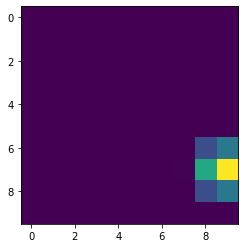

In [720]:
show_image(1)

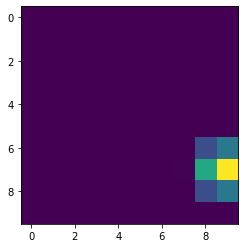

In [721]:
show_image(0)

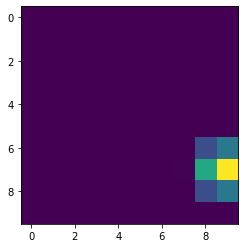

In [722]:
show_image(10)